## Dataset

For this video series, we will use the dialogues from the Friends TV series as the training corpus.

In [2]:
from convokit import Corpus, download

corpus = Corpus(download('friends-corpus'))

Dataset already exists at /Users/arapat/.convokit/downloads/friends-corpus


In [191]:
corpus.print_summary_stats()
print()

utterance = corpus.get_utterance('s07_e14_c01_u018')
print(utterance.speaker.id)
print(utterance.text)

Number of Speakers: 700
Number of Utterances: 67373
Number of Conversations: 3107

Rachel Green
Well, can I keep the presents and still be 29?


## Some preprocessing

* Mark start/end of a sentence: use a special character "@" to mark the start and end of a sentence
* Remove all special characters: only allow 0-9, a-z, A-Z, and selected punctuations (,.?!)

In [192]:
import re
re_pattern = "[^0-9a-zA-Z,.?!' ]"

def get_example(utterance, special_se='@'):
    speaker = utterance.speaker.id
    if speaker == "TRANSCRIPT_NOTE":
        # Only interested in conversations
        return ''
    # Limit vocabulary to 0-9, a-z, A-Z, and some punctuations (,.?!)
    example = re.sub(re_pattern, '', utterance.text)
    if special_se is None:
        return example
    return special_se + example + special_se


utterance = corpus.get_utterance('s07_e14_c01_u018')
print(get_example(utterance))

@Well, can I keep the presents and still be 29?@


## Language Models

A language model predicts the probability of sequences in a language.
* A token-level model predicts the next token (e.g., word) in a sequence
    * Example: For "can I keep the", it's likely to suggest "present" as the next token.
* A character-level model predicts the next character in a sequence
    * Example: From "can I keep the presen", it might predict "t" as the next character.
* We will build a character-level model

## The vocabulary, aka all characters

In [193]:
all_characters = set([])
for utterance in corpus.iter_utterances():
    example = get_example(utterance, None)
    all_characters.update(list(example))
all_characters = list(all_characters)

print("Dictionary size:", len(all_characters))
print(all_characters[:10])

Dictionary size: 67
['E', 'q', '4', 'k', '6', '2', 'j', 'O', 'B', 'a']


In [194]:
all_characters = sorted(all_characters)
stoi = {s: i + 1 for i, s in enumerate(all_characters)}
# Set special <SE> character to the index 0
stoi['@'] = 0
itos = {i: s for s, i in stoi.items()}

for i in range(5):
    print(f"{i}: {itos[i]}")
print("...")
for i in range(20, 25):
    print(f"{i}: {itos[i]}")
print("...")

0: @
1:  
2: !
3: ,
4: .
...
20: E
21: F
22: G
23: H
24: I
...


## Bigram

A bi-gram is “a pair of consecutive written units such as letters, syllables, or words” (Oxford Languages). For example, from the example above, we can generate following bi-grams.

In [195]:
utterance = corpus.get_utterance('s07_e14_c01_u018')
example = get_example(utterance)
print(example)
print()
# Convert a string to an array of character
chs = list(example)
for index, (ch1, ch2) in enumerate(zip(chs, chs[1:])):
    bigram = f"{ch1}{ch2}"
    print(bigram, end="\t")
    if (index + 1) % 8 == 0:
        print()

@Well, can I keep the presents and still be 29?@

@W	We	el	ll	l,	, 	 c	ca	
an	n 	 I	I 	 k	ke	ee	ep	
p 	 t	th	he	e 	 p	pr	re	
es	se	en	nt	ts	s 	 a	an	
nd	d 	 s	st	ti	il	ll	l 	
 b	be	e 	 2	29	9?	?@	

## Train bi-gram by counting

In [196]:
import torch

vocab_size = len(stoi)
N = torch.zeros((vocab_size , vocab_size), dtype=torch.int32)
for utterance in corpus.iter_utterances():
    example = get_example(utterance)
    chs = list(example)
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        N[ix1, ix2] += 1

### Visualize the counting matrix

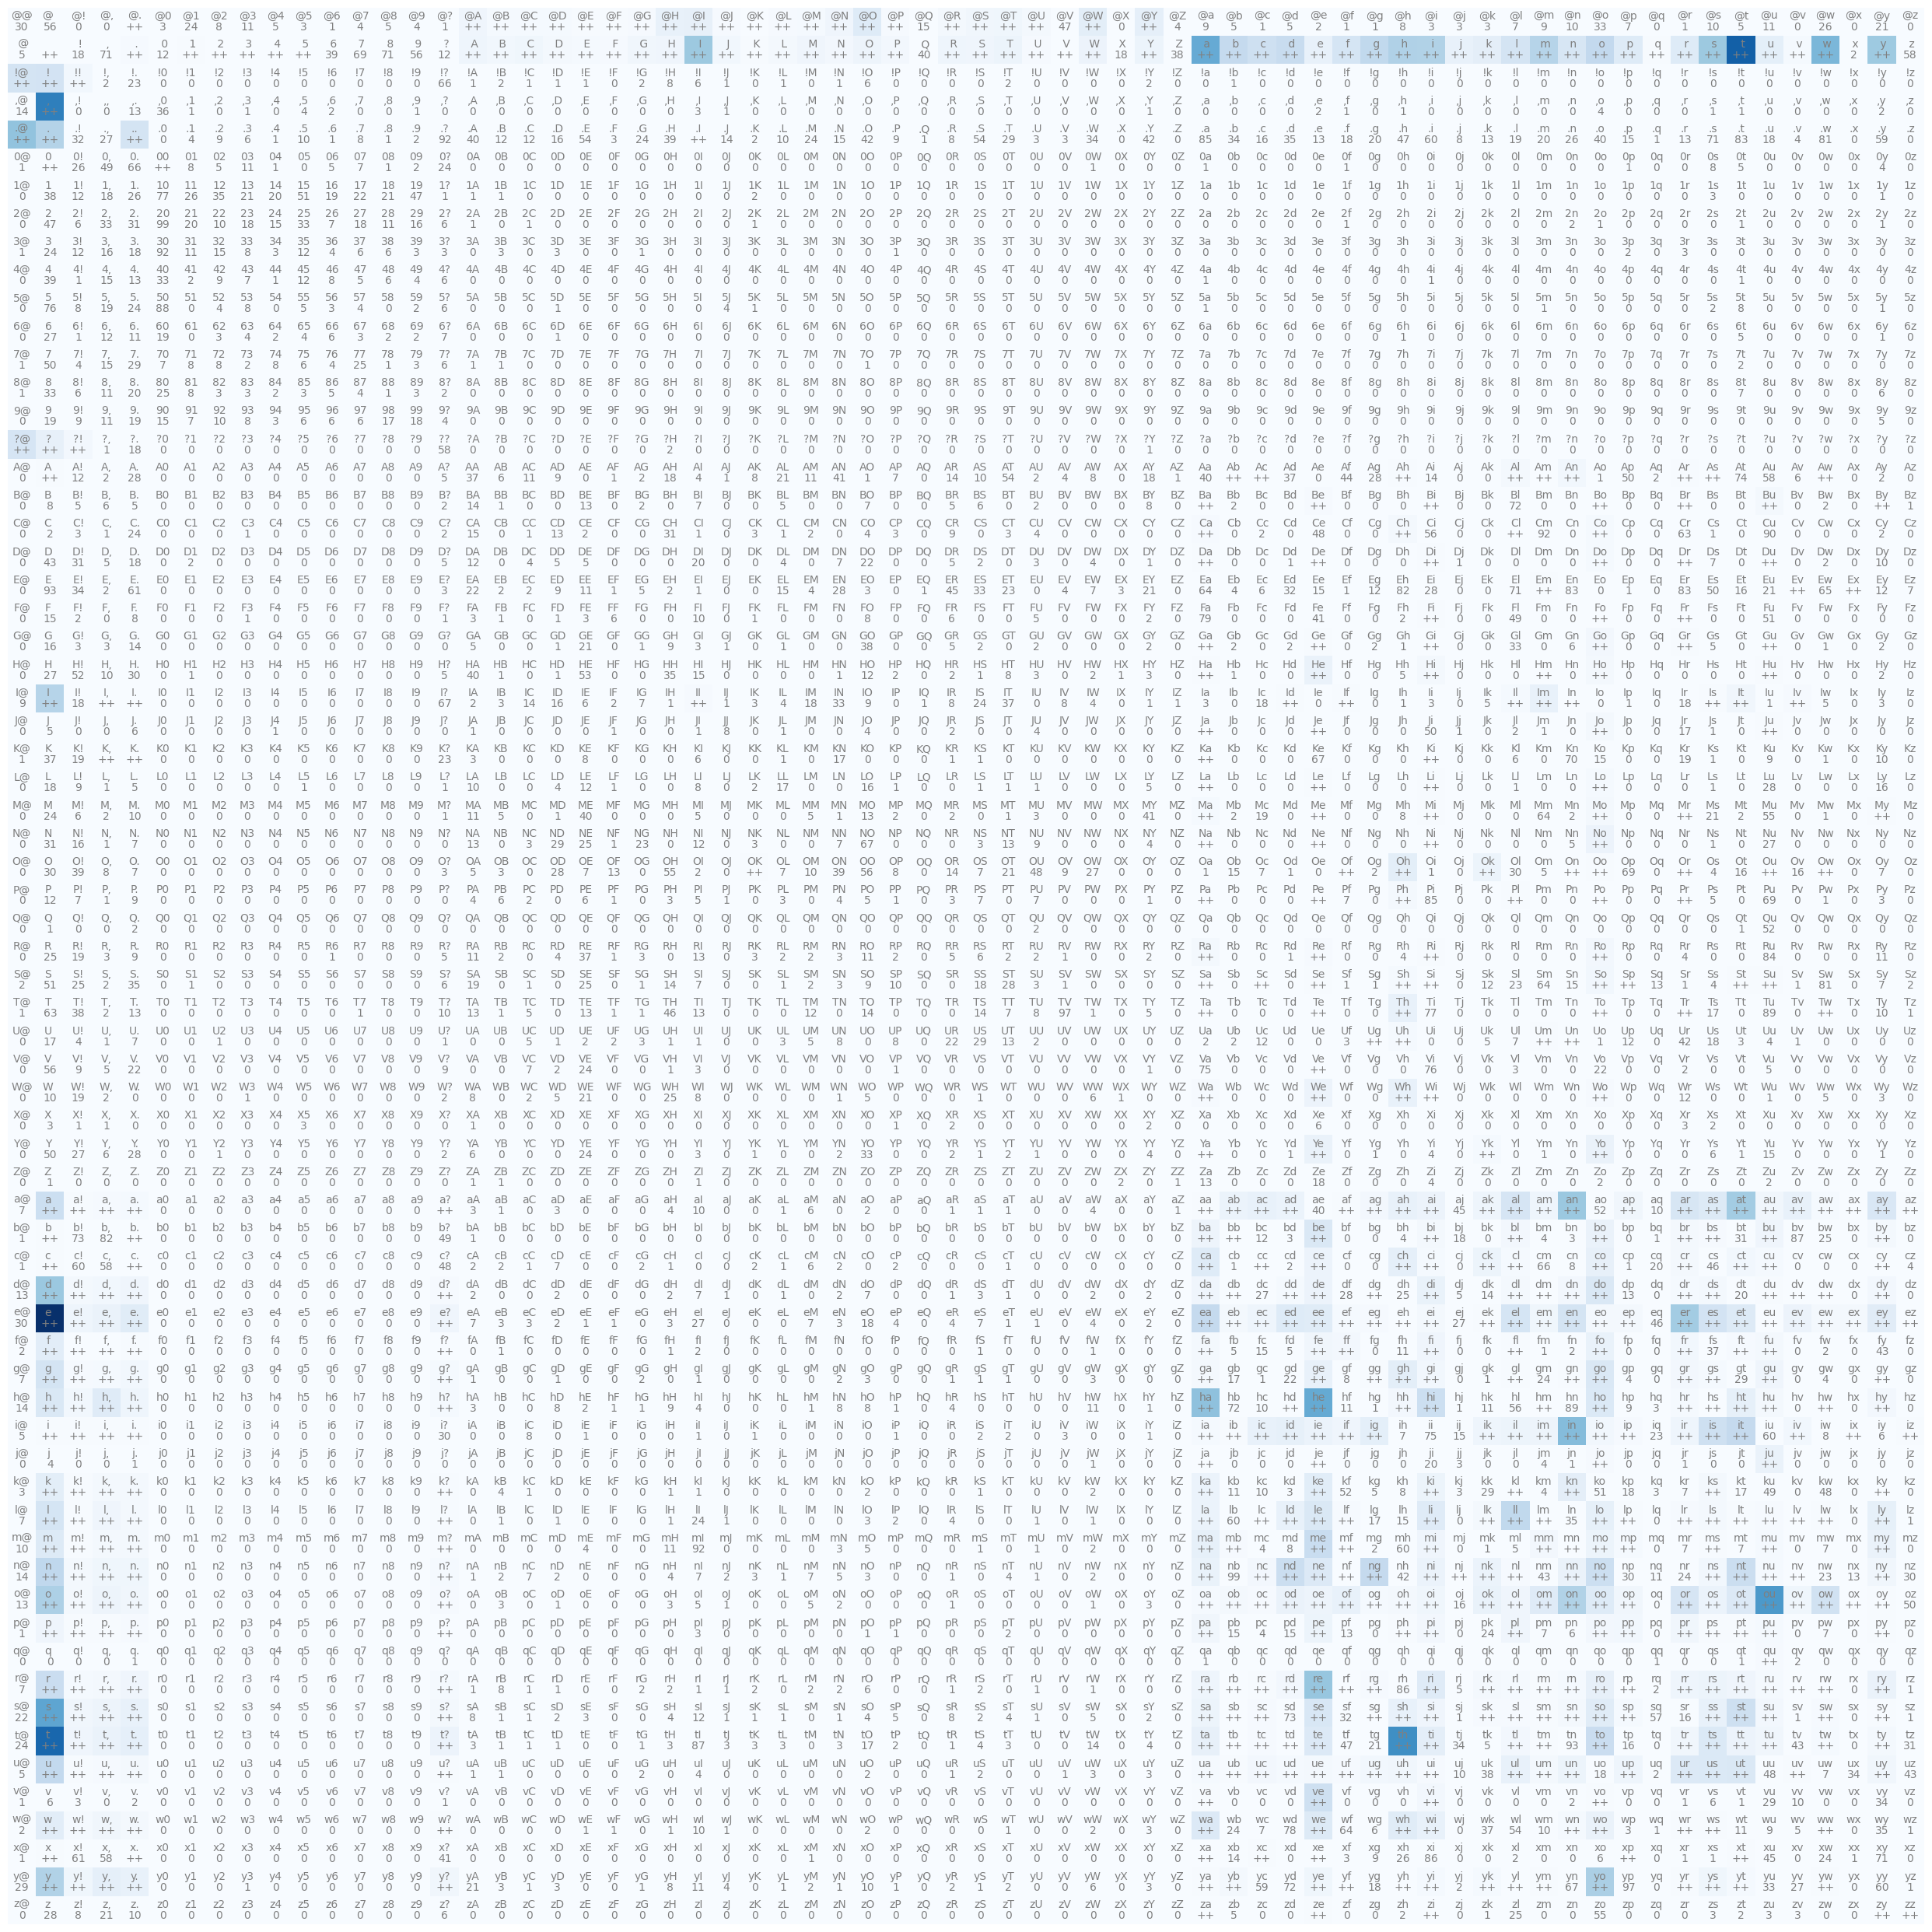

In [197]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(figsize=(32, 32))
plt.imshow(N, cmap='Blues')
for i in range(vocab_size):
    for j in range(vocab_size):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr.replace('$', '\$'), ha="center", va="bottom", color="gray")
        counts = '++'  # hide exact counts if it is >= 100
        if N[i, j].item() < 100:
            counts = N[i, j].item()
        plt.text(j, i, counts, ha="center", va="top", color="gray")
plt.axis('off');

### Example: characters following 'a'

In [240]:
index_a = stoi['a']
print(N[index_a])
print()

# Normalize to get a distribution
p_a = N[index_a].float()
p_a = p_a / p_a.sum()
print(p_a)

tensor([    7, 17707,   598,   830,  1011,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,   300,     3,     1,     0,     3,
            0,     0,     0,     4,    10,     0,     0,     1,     6,     0,
            2,     0,     0,     1,     1,     1,     0,     0,     4,     0,
            0,     1,   329,  4805,  6330,  4950,    40,   559,  2103,  5986,
         4525,    45,  3583, 13519,  3562, 30928,    52,  2562,    10, 13081,
        10589, 29005,  2726,  6201,   996,   178, 12376,   524],
       dtype=torch.int32)

tensor([3.8877e-05, 9.8342e-02, 3.3212e-03, 4.6097e-03, 5.6150e-03, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6662e-03, 1.6662e-05, 5.5539e-06,
        0.0000e+00, 1.6662e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.2215e-05,
        5.5539e-05, 0.0000e+00, 0.0000e+00, 5.5539e-06, 3.3323e-05, 0.0000e+00,
        1.1108e-05, 0.0000e+00, 0.0000e+

### Sampling from this distribution

In [241]:
for _ in range(8):
    ix = torch.multinomial(p_a, num_samples=1, replacement=True).item()
    print(f"a{itos[ix]}", end='\t')

an	au	at	ap	an	as	as	al	

## Sampling sentences

In [243]:
P = N.float()
P = P / P.sum(axis=1, keepdims=True)
# sanity check
torch.all(P[index_a] == p_a)

tensor(True)

In [245]:
g = torch.Generator().manual_seed(23610)

for i in range(5):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if ix == 0:
            break
        out.append(itos[ix])
    print(''.join(out) + '\n')

Are Yot, we ikinod Yo a ts Vatw!

Oulit e nder g, w d the ngor s y bo, yo kie oond. sa thanketrelis.. t!! yoon s..

We igo k I kay as wngodinohind tosle!

I inoo I ink Nowoth? weshaun. spaleve thint lkackatouhisic hto r I f loret stou. owhtays?

Oh, t?!! Imis. s ghes abeave gomaveysthacefirey l s. int I thader we s kaheerr ca I h a k tid ghe futotho fur me wennd I?!



## Train bi-gram by fitting a "neural network"

* *Basic idea*: Fit a model with maximum likelihood estimation
* *Objective*: Find the model parameters that *best explain* observed data
* *Method*: Maximize the _likelihood_ that the observed data occurred under that model

This exercise prepare us to bulid intuition on training a MLP in future.

## Negative log likelihood loss function

Example: maximize P("Are") = P("A") * P("r") * P("e")
* Maximize a * b * c
* Equivalent to maximize log(a * b * c)
* Equivalent to minimize -( log(a) + log(b) + log(c) )
* Equiavelent to minimize average of negative log likelihood

In [260]:
for phrase in ["think", "kahee"]:
    chs = list("@" + phrase + "@")
    probs = []
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        probs.append(P[ix1, ix2])
    probs = torch.tensor(probs)
    print(
        phrase,
        -probs.log().mean().item()
    )

think 4.518728256225586
kahee 4.840918064117432


## Train test split

In [319]:
xs = []
ys = []

for utterance in corpus.iter_utterances():
    example = get_example(utterance)
    chs = list(example)
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
xs[:10], ys[:10]

(tensor([ 0, 35, 49, 46, 59, 46, 60,  1, 55, 56]),
 tensor([35, 49, 46, 59, 46, 60,  1, 55, 56, 61]))

In [321]:
n = int(xs.shape[0] * 0.9)
x_train, y_train = xs[:n], ys[:n]
x_test, y_test = xs[n:], ys[n:]

## The "input layer"

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

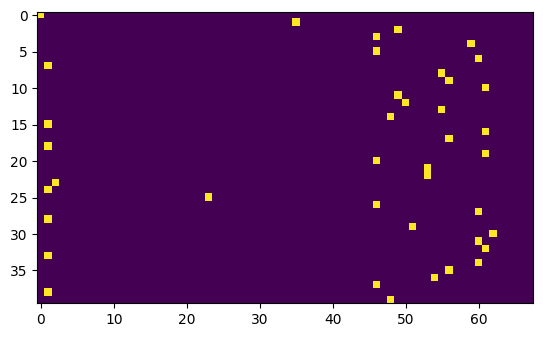

In [322]:
import torch.nn.functional as F

xenc = F.one_hot(xs[:40], num_classes=vocab_size).float()
plt.imshow(xenc)
xenc[0]

## Output layer

In [323]:
x = xs[:1]
y = ys[:1]
x, y

(tensor([0]), tensor([35]))

In [324]:
W = torch.randn((vocab_size, vocab_size))
xenc = F.one_hot(x, num_classes=vocab_size).float()
logits = xenc @ W  # log(counts)
counts = logits.exp()
prob = counts / counts.sum(axis=1, keepdims=True)
prob

tensor([[0.0073, 0.0168, 0.0153, 0.0052, 0.0039, 0.0297, 0.0069, 0.0034, 0.0008,
         0.0100, 0.0049, 0.0290, 0.0070, 0.0086, 0.0256, 0.0054, 0.0207, 0.0038,
         0.0027, 0.0079, 0.0158, 0.0158, 0.0024, 0.0052, 0.0054, 0.0341, 0.0153,
         0.0405, 0.0082, 0.0322, 0.0592, 0.0070, 0.0033, 0.0012, 0.0033, 0.0237,
         0.0025, 0.0308, 0.0242, 0.0031, 0.0338, 0.0202, 0.0159, 0.0207, 0.0051,
         0.0192, 0.0561, 0.0037, 0.0077, 0.0168, 0.0134, 0.0023, 0.0154, 0.0091,
         0.0027, 0.0029, 0.0098, 0.0165, 0.0184, 0.0067, 0.0199, 0.0243, 0.0472,
         0.0069, 0.0318, 0.0138, 0.0008, 0.0110]])

In [325]:
# Loss
loss = -prob[torch.arange(x.shape[0]), y].log().mean()
loss.item(), -P[xs, ys].log().mean().item()

(3.7427008152008057, 2.4047415256500244)

## Optimize the NLL over the "network"

In [415]:
# W = torch.randn((vocab_size, vocab_size), requires_grad=True)
lr = 0.1  # 1.0 # 10 # 50.0
num_iterations = 1000
batch_size = 10000
# lossi = []

for k in range(num_iterations):
    if batch_size is None:
        x = x_train
        y = y_train
    else:
        sample_indices = torch.randint(x_train.shape[0], size=(batch_size,))
        x = x_train[sample_indices]
        y = y_train[sample_indices]

    # Forward pass
    xenc = F.one_hot(x, num_classes=vocab_size).float()
    logits = xenc @ W  # log(counts)
    counts = logits.exp()
    prob = counts / counts.sum(axis=1, keepdims=True)
    loss = -prob[torch.arange(x.shape[0]), y].log().mean()

    # Backward pass
    W.grad = None
    loss.backward()
    W.data -= lr * W.grad

    # Loss on test data
    with torch.no_grad():
        xenc = F.one_hot(x_test, num_classes=vocab_size).float()
        logits = xenc @ W  # log(counts)
        counts = logits.exp()
        prob = counts / counts.sum(axis=1, keepdims=True)
        loss = -prob[torch.arange(x_test.shape[0]), y_test].log().mean()
        lossi.append(loss)

lossi[-1]

tensor(2.4273)

In [342]:
# Average loss from the count based method
-P[x_test, y_test].log().mean()

tensor(2.4134)

tensor(2.4273)

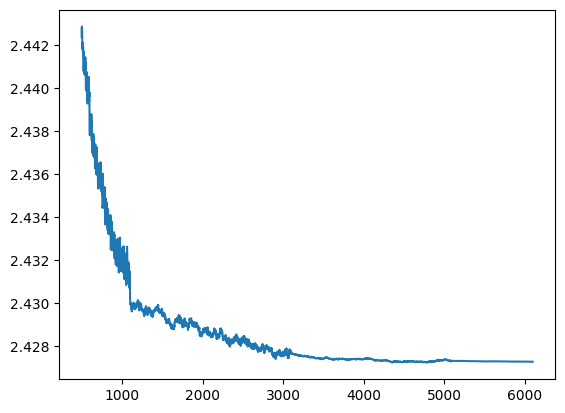

In [416]:
# plt.plot(range(len(lossi)), lossi)
plt.plot(range(len(lossi))[500:], lossi[500:])
lossi[-1]

In [419]:
g = torch.Generator().manual_seed(23610)

with torch.no_grad():
    for i in range(5):
        out = []
        ix = 0
        while True:
            ix = torch.tensor(ix)
            xenc = F.one_hot(ix, num_classes=vocab_size).float()
            logits = xenc @ W
            counts = logits.exp()
            prob = counts / counts.sum()
            ix = torch.multinomial(prob, num_samples=1, replacement=True, generator=g).item()
            if ix == 0:
                break
            out.append(itos[ix])
        print(''.join(out) + '\n')

Are Yeans w ikinod Yo a ts Vetw!

Oulit e nder g, w d the ngor s y bo, yo kie oond. sathat aberelis.. y!! yoon s..

We igo k I kay as wngodinohind tosle!

I inoo I ink Nowoth? weshaun. spaleve thint lkackatouhisic hto r I f loret stou. owhtays?

Oh, t?!! Imis. s ghes abeave gomaveysthacefirey l s. int I thader we s kaheerr ca Im ca k tid ghe futotho fur me wennd I?!



## The toy neural network

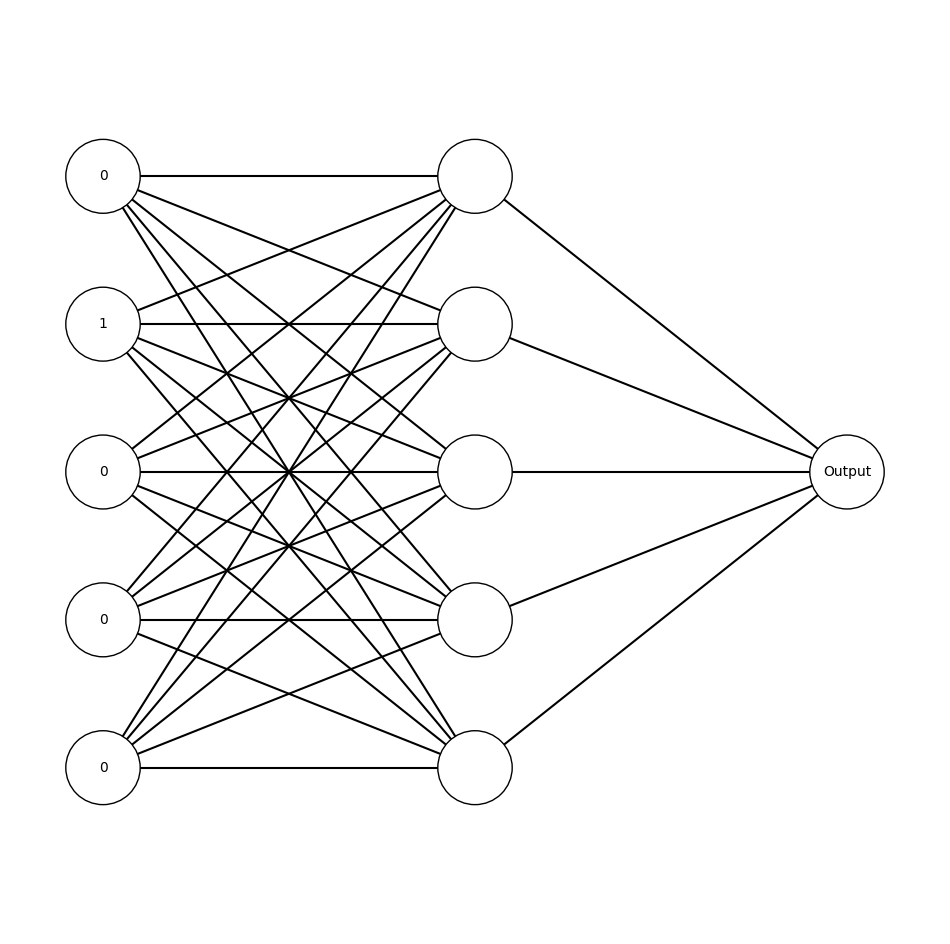

## Notes

* This is not scalable, hard to create a table for n-gram if n > 2, because the table will get exponentially large
* Performance is slightly worse, but it is very scalable

# Appendix

## Compare W and P

In [417]:
with torch.no_grad():
    prob_from_W = W[0].exp() / W[0].exp().sum()
prob_from_W

tensor([5.3421e-04, 6.4844e-04, 3.4226e-04, 3.3944e-04, 3.3105e-03, 2.6325e-04,
        3.2940e-04, 3.9087e-04, 2.3584e-04, 3.4269e-04, 3.1451e-04, 2.4415e-04,
        2.3956e-04, 3.2173e-04, 3.7808e-04, 3.3564e-04, 5.3355e-02, 1.6512e-02,
        1.8977e-02, 1.5793e-02, 7.1907e-03, 6.0068e-03, 1.2393e-02, 9.5793e-02,
        1.0464e-01, 9.8822e-03, 1.2314e-03, 1.4456e-02, 1.7815e-02, 5.4953e-02,
        1.6431e-01, 1.1463e-02, 4.3708e-04, 2.1333e-02, 4.1486e-02, 4.7676e-02,
        2.1374e-02, 6.0613e-04, 1.3044e-01, 2.4972e-04, 1.1500e-01, 3.4571e-04,
        3.5569e-04, 2.9569e-04, 2.8674e-04, 1.9993e-04, 2.0391e-04, 9.8052e-05,
        3.3277e-04, 2.6276e-04, 1.2136e-04, 3.0122e-04, 2.8861e-04, 3.6673e-04,
        3.4714e-04, 2.6361e-04, 4.5305e-04, 2.9393e-04, 3.0056e-04, 2.4336e-04,
        1.9227e-04, 3.4549e-04, 3.5363e-04, 3.0561e-04, 4.1716e-04, 2.5080e-04,
        4.8354e-04, 3.4334e-04])

In [418]:
P[0]

tensor([4.8909e-04, 9.1297e-04, 0.0000e+00, 0.0000e+00, 3.8475e-03, 4.8909e-05,
        3.9127e-04, 1.3042e-04, 1.7933e-04, 8.1516e-05, 4.8909e-05, 1.6303e-05,
        6.5212e-05, 8.1516e-05, 6.5212e-05, 1.6303e-05, 5.3702e-02, 1.6857e-02,
        1.9172e-02, 1.6238e-02, 7.7114e-03, 6.3745e-03, 1.2912e-02, 9.4835e-02,
        1.0662e-01, 1.0564e-02, 1.6955e-03, 1.4233e-02, 1.8096e-02, 5.5268e-02,
        1.6499e-01, 1.1787e-02, 2.4455e-04, 2.2074e-02, 4.2421e-02, 4.8094e-02,
        2.1145e-02, 7.6625e-04, 1.2995e-01, 0.0000e+00, 1.1486e-01, 6.5212e-05,
        1.4673e-04, 8.1516e-05, 1.6303e-05, 8.1516e-05, 3.2606e-05, 1.6303e-05,
        1.6303e-05, 1.3042e-04, 4.8909e-05, 4.8909e-05, 4.8909e-05, 1.1412e-04,
        1.4673e-04, 1.6303e-04, 5.3800e-04, 1.1412e-04, 0.0000e+00, 1.6303e-05,
        1.6303e-04, 8.1516e-05, 1.7933e-04, 0.0000e+00, 4.2388e-04, 0.0000e+00,
        3.4237e-04, 0.0000e+00])

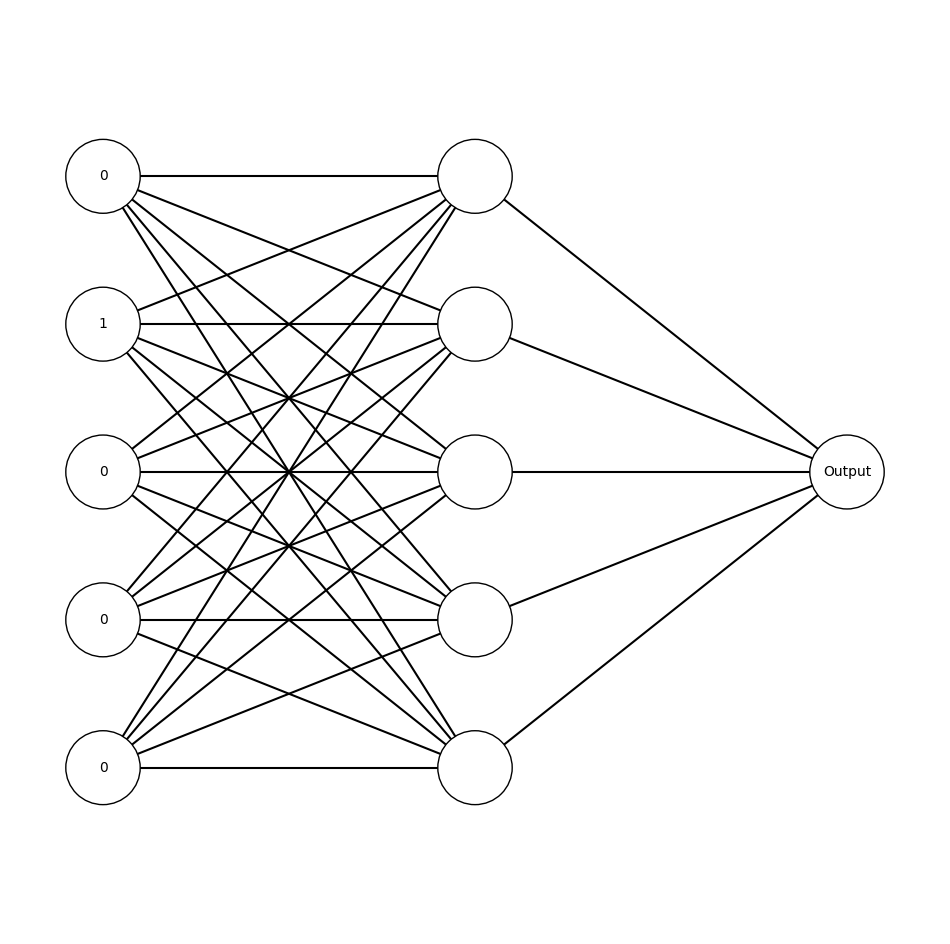

In [218]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :param ax: matplotlib.axes.Axes instance
    :param left: x-coordinate of the left neurons
    :param right: x-coordinate of the right neurons
    :param bottom: y-coordinate of the bottom neurons
    :param top: y-coordinate of the top neurons
    :param layer_sizes: list containing the sizes of each layer
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
            # Annotation
            if n == 0:
                char = '1' if m == 1 else '0'
                ax.text(n*h_spacing + left, layer_top - m*v_spacing, char, ha='center', va='center', zorder=5)
            elif n == n_layers - 1:
                ax.text(n*h_spacing + left, layer_top - m*v_spacing, 'Output', ha='center', va='center', zorder=5)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(12, 12))

# No ticks
ax.axis('off')

# Draw the neural network
draw_neural_net(ax, .1, .9, .1, .9, [5, 5, 1])

# Show the plot
plt.show()
